# t for proportions?

Some of the hypothesis tests in this course have used a 
 test statistic and some have used a 
 test statistic. To get the correct p-value, you need to use the right type of test statistic.

Do tests of proportion(s) use a z or a t test statistic and why?

- z: The test statistic for proportion(s) has only one estimate of a parameter instead of two.

# Test for single proportions

In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was greater than 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.

In [2]:
import pandas as pd
late_shipments = pd.read_feather("dataset/late_shipments.feather")

In [3]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = late_shipments["late"].value_counts(normalize= True)["Yes"]

# Calculate the sample size
n = len(late_shipments["late"] == "Yes")

# Print p_hat and n
print(p_hat, n)

0.061 1000


In [10]:
import numpy as np
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = (late_shipments['late'] == "Yes").mean()

# Calculate the sample size
n = len(late_shipments)

# Calculate the numerator and denominator of the test statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1- p_0) / n)

# Calculate the test statistic
z_score = numerator / denominator

# Print the result
print(z_score)

0.13315591032282698


In [14]:
from scipy.stats import norm
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.44703503936503364


# Test of two proportions

You may wonder if the amount paid for freight affects whether or not the shipment was late. Recall that in the `late_shipments` dataset, whether or not the shipment was late is stored in the late column. Freight costs are stored in the `freight_cost_group` column, and the categories are "`expensive`" and "`reasonable`".

The hypotheses to test, with "`late`" corresponding to the proportion of late shipments for that group



In [19]:
p_hats = pd.DataFrame({'freight_cost_group': ['expensive', 'reasonable'],
        'late': ['Yes', 'Yes'],
        'proportion': [0.082569, 0.035165]})
p_hats

,freight_cost_group,late,proportion
0,expensive,Yes,0.082569
1,reasonable,Yes,0.035165


In [20]:
ns = pd.DataFrame({'freight_cost_group': ['expensive', 'reasonable'],
        'counts': [545, 455]})

ns

,freight_cost_group,counts
0,expensive,545
1,reasonable,455


In [21]:
p_hats["Success"] = p_hats["proportion"] * ns["counts"]
p_hats

,freight_cost_group,late,proportion,Success
0,expensive,Yes,0.082569,45.000105
1,reasonable,Yes,0.035165,16.000075


In [25]:
# Calculate the pooled estimate of the population proportion
p_hat = (p_hats["Success"].sum()) / (ns["counts"].sum())

# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = p_hat * (1 - p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat / ns.loc[0,"counts"] + p_hat_times_not_p_hat / ns.loc[1,"counts"] 

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Calculate the z-score
z_score = (p_hats.loc[0,"proportion"] - p_hats.loc[1,"proportion"]) / std_error

# Calculate the p-value from the z-score
p_value = 1-norm.cdf(z_score)

# Print p_value
print(p_value)

0.0009072136753094373


# proportions_ztest() for two samples

That took a lot of effort to calculate the p-value, so while it is useful to see how the calculations work, it isn't practical to do in real-world analyses. For daily usage, it's better to use the `statsmodels` package.

In [29]:
late_shipments.columns

Index(['id', 'country', 'managed_by', 'fulfill_via', 'vendor_inco_term',
       'shipment_mode', 'late_delivery', 'late', 'product_group',
       'sub_classification', 'vendor', 'item_description',
       'molecule_test_type', 'brand', 'dosage', 'dosage_form',
       'unit_of_measure_per_pack', 'line_item_quantity', 'line_item_value',
       'pack_price', 'unit_price', 'manufacturing_site',
       'first_line_designation', 'weight_kilograms', 'freight_cost_usd',
       'freight_cost_groups', 'line_item_insurance_usd'],
      dtype='object')

In [30]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")["late"].value_counts()

# Print the counts
print(late_by_freight_cost_group)

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      439
                     Yes      16
Name: late, dtype: int64


In [31]:
from statsmodels.stats.proportion import proportions_ztest

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([45, 16])

# Create an array of the total number of rows in each freight_cost_group
n = np.array([500+45, 439+16])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts, 
                                     nobs=n,
                                     alternative="larger")


# Print the results
print(stat, p_value)

3.1190401865206128 0.0009072060637051224


# The chi-square distribution

Chi-square hypothesis tests rely on the chi-square distribution. Like the t-distribution, it has degrees of freedom and non-centrality parameters.

The plots show the PDF and CDF for a chi-square distribution (solid black line), and for comparison show a normal distribution with the same mean and variance (gray dotted line).

Which statement about the chi-square distribution is true?

<center><img src="images/03.01.png"  style="width: 400px, height: 300px;"/></center>

- Like the t-distribution, the chi-square distribution has degrees of freedom and non-centrality parameters. When these numbers are large, the chi-square distribution can be approximated by a normal distribution.

# How many tails for chi-square tests?

Unlike pingouin.ttest() and statsmodels.stats.proportion.proportions_ztest(), pingouin.chi2_independence() does not have an alternative argument to specify which tails are considered by the alternative hypothesis.

Which tail is almost always considered in chi-square tests?

- Right-tailed. Because it is squared and non-negative

# Performing a chi-square test

The chi-square independence test compares proportions of successes of one categorical variable across the categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract. These are International Chamber of Commerce (ICC) international commercial terms, or incoterms for short.

The `late_shipments` dataset includes a `vendor_inco_term` that describes the incoterms that applied to a given shipment. 

Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of 0.01.

H0: `vendor_inco_term` and `freight_cost_group` are independent.

HA: `vendor_inco_term` and `freight_cost_group` are associated.

In [33]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

# Print props
print(props)

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: freight_cost_groups, dtype: float64


In [34]:
# Convert props to wide format
wide_props = props.unstack()

# Print wide_props
print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
DDU                        NaN    1.000000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


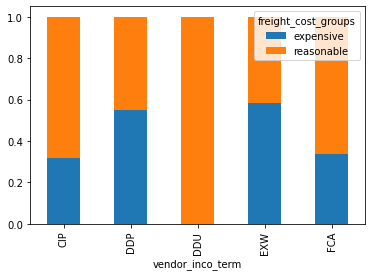

In [36]:
import matplotlib.pyplot as plt
# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

In [39]:
# import pingouin

# # Determine if freight_cost_group and vendor_inco_term are independent
# expected, observed, stats = pingouin.chi2_independence(data=late_shipments, 
# x='vendor_inco_term',y='freight_cost_groups', correction=False)

# # Print results
# print(stats[stats['test'] == 'pearson']) 

In [75]:
from scipy.stats import chi2_contingency

# Assuming 'late_shipments' is your DataFrame
contingency_table = pd.crosstab(late_shipments['vendor_inco_term'], late_shipments['freight_cost_groups'])

# Perform chi-square test
chi2, p, _, expected = chi2_contingency(contingency_table, correction=False)

# Display results
result_df = pd.DataFrame({
    'Chi-Square': [chi2],
    'p-value': [p],
    'Degrees of Freedom': [contingency_table.size - sum(contingency_table.shape) + contingency_table.ndim - 1]
})
result_df

,Chi-Square,p-value,Degrees of Freedom
0,34.805072,5.093922e-07,4


- Reject the null that says the two columns are independent. That means they are associated.

# Visualizing goodness of fit

The chi-square goodness of fit test compares proportions of each level of a categorical variable to hypothesized values. Before running such a test, it can be helpful to visually compare the distribution in the sample to the hypothesized distribution.

Recall the vendor incoterms in the `late_shipments` dataset. You hypothesize that the four values occur with these frequencies in the population of shipments.

In [85]:
incoterm_counts = late_shipments["vendor_inco_term"].sort_values().value_counts()[:4].reset_index().reset_index(drop=True)
print(incoterm_counts)
incoterm_counts.columns

  index  vendor_inco_term
0   EXW               732
1   FCA               111
2   DDP               100
3   CIP                56


Index(['index', 'vendor_inco_term'], dtype='object')

In [79]:
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Print n_total
print(n_total)

1000


In [80]:
# Creating the DataFrame
data = {'vendor_inco_term': ['EXW',  'FCA', 'DDP','CIP'],
        'prop': [0.75,  0.10, 0.10, 0.05]}

hypothesized = pd.DataFrame(data)

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Print the modified hypothesized DataFrame
print(hypothesized)

  vendor_inco_term  prop      n
0              EXW  0.75  750.0
1              FCA  0.10  100.0
2              DDP  0.10  100.0
3              CIP  0.05   50.0


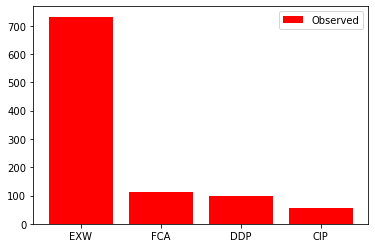

In [96]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts["index"], incoterm_counts["vendor_inco_term"],color="red",label="Observed")
plt.legend()
plt.show()

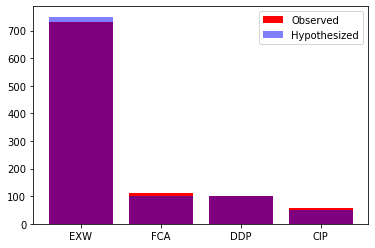

In [97]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts["index"], incoterm_counts["vendor_inco_term"],color="red",label="Observed")

# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="blue",alpha=0.5,label="Hypothesized")
plt.legend()
plt.show()

# Performing a goodness of fit test

The bar plot of vendor_inco_term suggests that the distribution across the four categories was quite close to the hypothesized distribution. You'll need to perform a chi-square goodness of fit test to see whether the differences are statistically significant.

Recall the hypotheses for this type of test:

H0: The sample matches with the hypothesized distribution.

HA: The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, we'll set a significance level of 0.1

In [108]:
from scipy.stats import chi2_contingency
result = chi2_contingency([incoterm_counts["vendor_inco_term"], hypothesized['n']])
chi2, p, dof, freq = result
print(p)

0.7695466994806094


- Fail to reject null. They closely mirror each other.

In [107]:
# from scipy.stats import chisquare
# # Perform a goodness of fit test on the incoterm counts n
# gof_test = chisquare(f_obs=incoterm_counts["vendor_inco_term"], f_exp=hypothesized['n'])


# # Print gof_test results
# print(gof_test)